### DATA 620 Web Analytics
### Sentiment Analysis of Presidential Inauguration Speeches
Lin Li and Tony Mai

Goal: Analyze the inaugural addresses of U.S. presidents. Analyze the difference between the 19th and 20th century U.S. president inaugural speeches.

### Part 1 - Collect inuagural speeches of presidents

In [88]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

We adapted the code for scraping the speech data from https://medium.com/@med.taha.elahmar/an-nlp-case-study-with-us-presidents-inaugural-speeches-part-1-2-data-collection-and-f1e2c5df5e50

We added comments to the code to demonstrate our understanding of the script

In [89]:
# Get list of urls of individual speech from website

def get_urls(url):
    '''Returns list of transcript urls'''
    
    page = requests.get(url).text 
    soup=BeautifulSoup(page, 'lxml')
    url_table = soup.find("table", class_='table').find_all("a")
    return [u["href"] for u in url_table]

urls = get_urls("https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/inaugural-addresses")

In [90]:
# Scrape speech transcripts from each url

transcripts = pd.DataFrame()
def get_transcripts(urls, transcripts):
    for u in urls:
        page = requests.get(u).text
        soup = BeautifulSoup(page, 'lxml')
        president = soup.find("h3", class_="diet-title").text
        year = soup.find("span", class_="date-display-single").text.split(',')[1].strip()
        content = soup.find("div", class_="field-docs-content").text
        record = {
            'president' : president,
            'year' : year,
            'content' : content
        }
        transcripts = transcripts.append(record, ignore_index=True)

    return transcripts
data = get_transcripts(urls,transcripts)


In [91]:
data.to_csv("president_speeches.csv", index = False, header = True)

### Part 2 - Text processing


In [92]:
import re
import string
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

In [93]:
speeches = pd.read_csv('https://raw.githubusercontent.com/lincarrieli/DATA620-Web-Analytics/main/president_speeches.csv')
speeches.head()

,content,president,year
0,fellow citizens of the senate and of the house...,George Washington,1789
1,fellow citizensi am again called upon by the v...,George Washington,1793
2,"when it was first perceived, in early times, t...",John Adams,1797
3,friends and fellow citizenscalled upon to unde...,Thomas Jefferson,1801
4,"proceeding, fellow citizens, to that qualifica...",Thomas Jefferson,1805


In [94]:
# Use regex to remove noise in the content 
def clean_content(content):
    content = content.replace('\n', '')
    content = content.replace(':', '')
    content = content.replace('-', ' ')
    content = content.lower()
    return content


In [95]:
# Create new dataframe with clean content
clean_data = speeches
clean_data['content'] = clean_data['content'].map(clean_content)
#clean_data['content']

In [96]:
# Use NLP to further process the content

def process_content (text):
    # remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # remove stopwords
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_words

clean_data['content'].apply(process_content)


0     [fellow, citizens, senate, house, representati...
1     [fellow, citizensi, called, upon, voice, count...
2     [first, perceived, early, times, middle, cours...
3     [friends, fellow, citizenscalled, upon, undert...
4     [proceeding, fellow, citizens, qualification, ...
5     [unwilling, depart, examples, revered, authori...
6     [add, solemnity, oath, obligations, imposed, s...
7     [destitute, feeling, deeply, affected, strong,...
8     [fellow, citizensi, shall, attempt, describe, ...
9     [compliance, usage, coeval, existence, federal...
10    [fellow, citizensabout, undertake, arduous, du...
11    [fellow, citizensthe, american, people, expres...
12    [fellow, citizensthe, practice, predecessors, ...
13    [called, retirement, supposed, continue, resid...
14    [fellow, citizenswithout, solicitation, part, ...
15    [elected, american, people, highest, office, k...
16    [countrymenit, relief, feel, heart, know, pers...
17    [fellow, citizensi, appear, day, take, sol

Use a functionality of CountVectorizer function that eliminates stop words. To keep track of the presidents, we create a new column that is the concatenation of the year and president’s name and surname. This column will be the index of our term-document matrix.

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(clean_data.content)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = clean_data[['year','president']].apply(lambda x: ':'.join(str(s) for s in x), axis=1)
data_dtm.head()

,000,100,108,11,120,125,13,14th,15th,16,...,yorktown,young,younger,youngest,youth,youthful,zeal,zealous,zealously,zone
1789:George Washington,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1793:George Washington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1797:John Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1801:Thomas Jefferson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1805:Thomas Jefferson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


This large matrix gives us a numerical representation of our corpus by specifying the words used in each speech.

# # Exploratory data analysis

In [133]:
data = data_dtm.transpose()
data.head()

,1789:George Washington,1793:George Washington,1797:John Adams,1801:Thomas Jefferson,1805:Thomas Jefferson,1809:James Madison,1813:James Madison,1817:James Monroe,1821:James Monroe,1825:John Quincy Adams,...,1985:Ronald Reagan,1989:George Bush,1993:William J. Clinton,1997:William J. Clinton,2001:George W. Bush,2005:George W. Bush,2009:Barack Obama,2013:Barack Obama,2017:Donald J. Trump,2021:Joseph R. Biden
000,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,1
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
120,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
len(data)

9010

In [100]:
#calculate word frequency

top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

In [101]:
for president, top_words in top_dict.items():
    print(president)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

1789:George Washington
government, public, present, citizens, country, ought, duty, people, united, happiness, far, measures, shall, nature
---
1793:George Washington
shall, oath, instance, incurring, government, confidence, citizensi, united, honor, requires, presence, knowingly, occasion, constitutional
---
1797:John Adams
people, government, nations, country, states, nation, constitution, foreign, honor, justice, mind, congress, spirit, public
---
1801:Thomas Jefferson
government, let, fellow, principle, shall, man, citizens, good, peace, safety, honest, country, confidence, opinion
---
1805:Thomas Jefferson
public, citizens, fellow, state, shall, time, constitution, reason, false, limits, states, peace, duties, duty
---
1809:James Madison
nations, public, states, rights, country, peace, best, confidence, united, improvements, rendered, look, foreign, spirit
---
1813:James Madison
war, british, united, country, spirit, states, citizens, nation, long, honorable, political, justice, p

In [102]:
#identify the words are that used in multiple speeches
# Look at the most common top words --> add them to the stop word list
from collections import Counter
# The top 10 most recurrent words in our speeches
words = []
for president in data.columns:
    top = [word for (word,count) in top_dict[president]]
    for t in top:
        words.append(t)
# List aggregation
Counter(words).most_common(15)

[('people', 48),
 ('government', 44),
 ('nation', 38),
 ('shall', 36),
 ('great', 34),
 ('country', 31),
 ('peace', 28),
 ('world', 28),
 ('states', 26),
 ('public', 25),
 ('power', 25),
 ('new', 25),
 ('citizens', 24),
 ('time', 24),
 ('united', 21)]

In [103]:
# If more than half the speeches have it as a top word, exclude it  from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > len(data.columns)/2]
add_stop_words

['people', 'government', 'nation', 'shall', 'great', 'country']

In [104]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(clean_data.content)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = clean_data[['year','president']].apply(lambda x: ':'.join(str(s) for s in x), axis=1)

## Data Visualization



In [ ]:
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

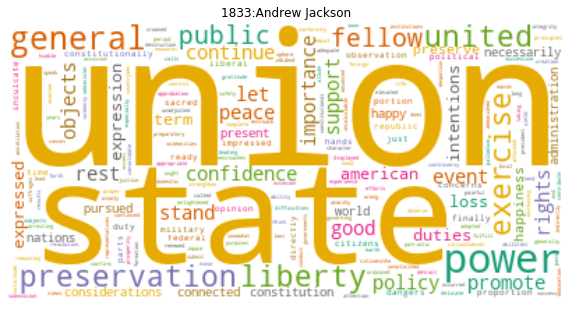

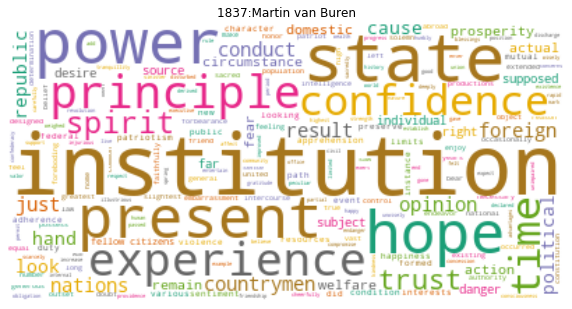

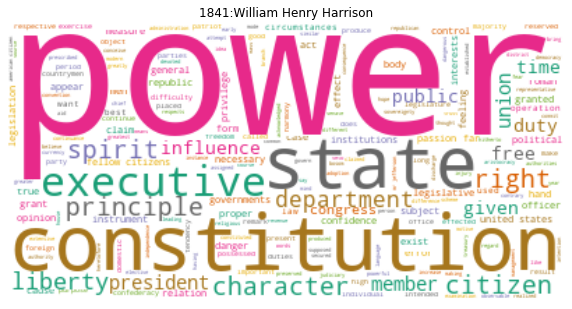

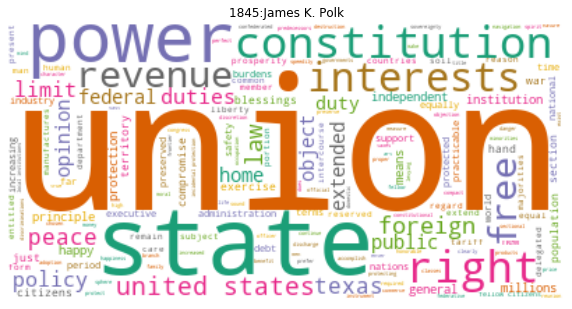

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_words, background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
clean_data.index = clean_data[['year','president']].apply(lambda x: ':'.join(str(s) for s in x), axis=1)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
president_names = data.columns
# Create subplots for each speech
for index, speech in enumerate(data.columns):
    
    if index > 10:
        wc.generate(clean_data.content[speech])
        #plt.subplot(4, 3, index-2+1)
        plt.imshow( wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(president_names[index])
        plt.show()

In [108]:
#unique words per speech

# Words counting
unique_list = []
for speech in data.columns:
    uniques = data[speech].to_numpy().nonzero()[0].size
    unique_list.append(uniques)
# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(data.columns, unique_list)), columns=['speech', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words', ascending=False)

In [109]:
data_unique_sort

,speech,unique_words
13,1841:William Henry Harrison,1607
30,1909:William Howard Taft,1194
25,1889:Benjamin Harrison,1132
14,1845:James K. Polk,1095
12,1837:Martin van Buren,1086
8,1821:James Monroe,1031
27,1897:William McKinley,1017
34,1925:Calvin Coolidge,998
33,1921:Warren G. Harding,969
16,1853:Franklin Pierce,958


# Model generation : Topic Modeling

In [118]:
from nltk import word_tokenize, pos_tag
def nouns_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_nouns_adjs = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(all_nouns_adjs)
# Apply the nouns function to the transcripts to filter only on nouns and adjectives
data_nouns_adjs = pd.DataFrame(clean_data.content.apply(nouns_adjs))
data_nouns_adjs.head()

,content
1789:George Washington,fellow citizens senate house representativesam...
1793:George Washington,fellow citizensi upon voice country functions ...
1797:John Adams,early times middle course america unlimited su...
1801:Thomas Jefferson,friends fellow duties first executive office c...
1805:Thomas Jefferson,proceeding fellow citizens qualification const...


In [119]:
#reconstruct the document matrix
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
# Re-add the additional stop words since we are recreating the document-term matrix
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
# Recreate a document-term matrix with nouns and adjectives
cvna = CountVectorizer(stop_words=stop_words)
data_cvna = cvna.fit_transform(data_nouns_adjs.content)
data_dtmna  = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adjs.index
data_dtmna.head()

,14th,15th,18th,19th,200th,20th,21st,30th,50th,abandonment,...,york,yorktown,young,younger,youngest,youth,youthful,zeal,zealous,zone
1789:George Washington,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793:George Washington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1797:John Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1801:Thomas Jefferson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1805:Thomas Jefferson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [128]:
# Create the gensim corpus
from gensim import matutils, models
import scipy.sparse
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

AttributeError: module 'numpy.random' has no attribute 'default_rng'